In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [116]:
data = pd.read_csv("eleicoes_2006_a_2010.csv")
teste = pd.read_csv("eleicoes_2014.csv")

A variável 'data' terá os dados para a criação e validação dos modelos, que são dados das eleições de 2006 e 2010.
A variável 'teste' terá os dados para o teste dos modelos, que são dados das eleições de 2014.

In [117]:
data = data.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])
teste = teste.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])

Removi as colunas "media_receita" e "media_despesa", pois elas são derivadas da divisão de "total_receita" por "quantidade_doadores" e "total_despesa" por "quantidade_fornecedores", respectivamente.
Removi também as colunas nome e sequencial_candidato, porque não são relevantes para essa análise.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6707bfd30>,
      dtype=object)

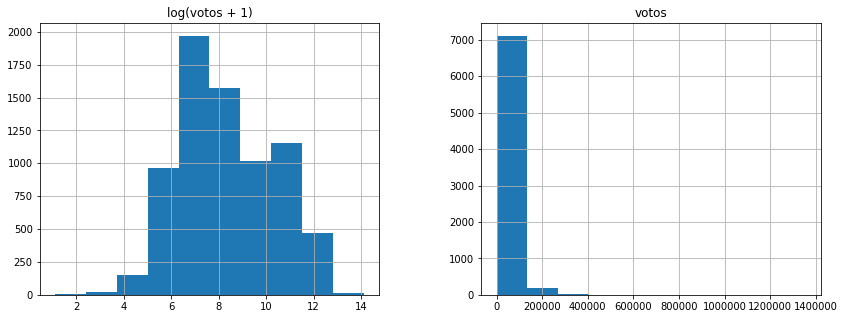

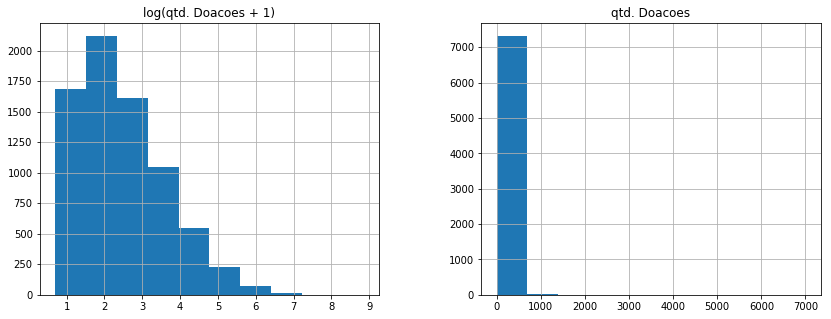

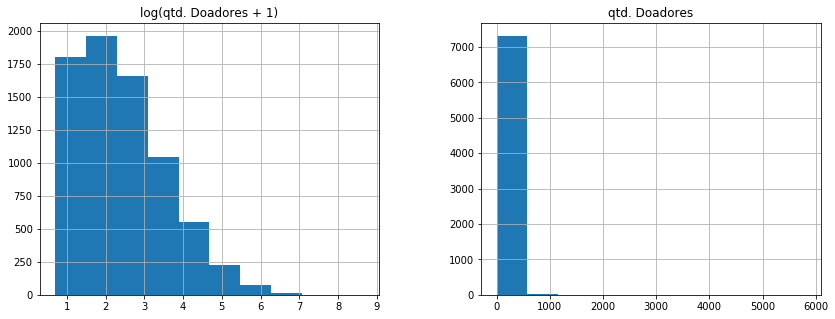

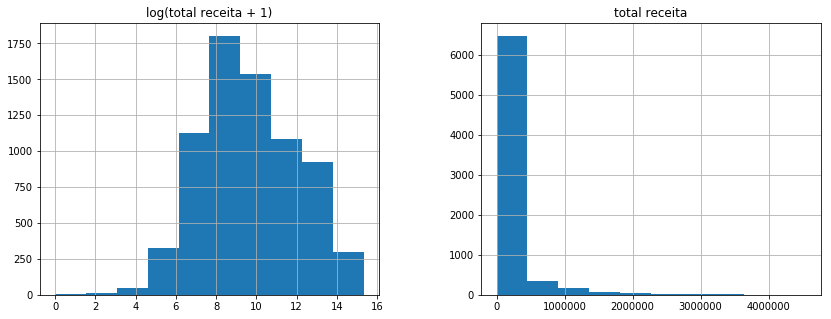

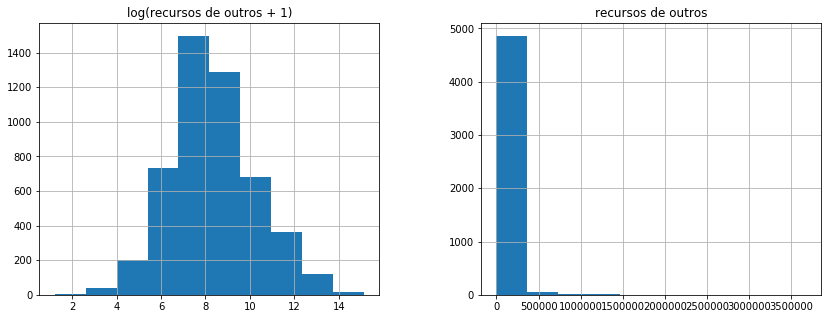

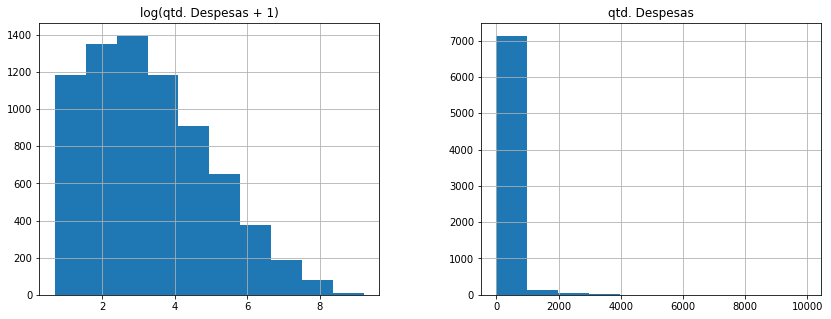

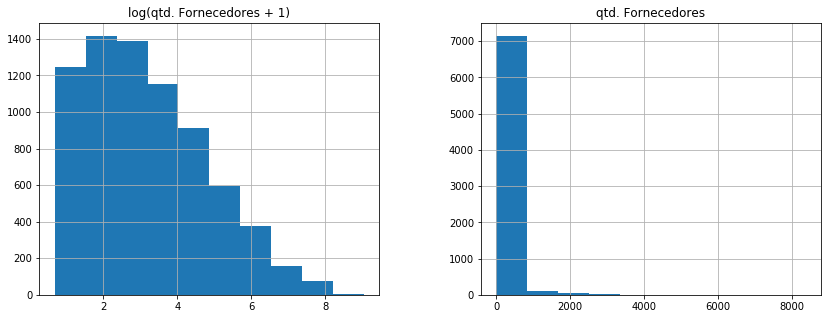

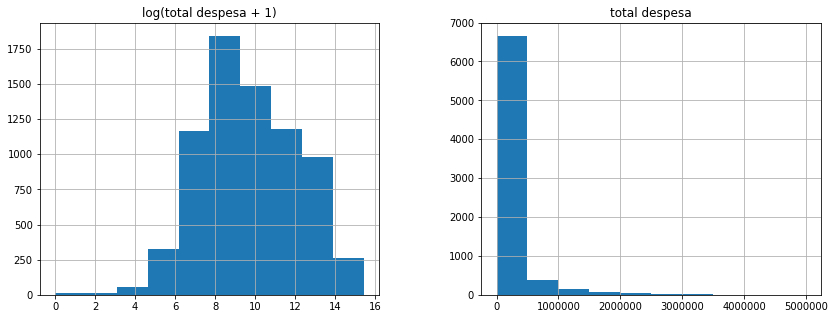

In [118]:
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)

df_votos = pd.DataFrame({"votos":data["votos"], "log(votos + 1)":np.log1p(data["votos"])})
df_votos.hist()

df_qtdDoacoes = pd.DataFrame({"qtd. Doacoes":data["quantidade_doacoes"], "log(qtd. Doacoes + 1)":np.log1p(data["quantidade_doacoes"])})
df_qtdDoacoes.hist()

df_qtdDoadores = pd.DataFrame({"qtd. Doadores":data["quantidade_doadores"], "log(qtd. Doadores + 1)":np.log1p(data["quantidade_doadores"])})
df_qtdDoadores.hist()

df_totalReceita = pd.DataFrame({"total receita":data["total_receita"], "log(total receita + 1)":np.log1p(data["total_receita"])})
df_totalReceita.hist()

df_recursosOutros = pd.DataFrame({"recursos de outros":data["recursos_de_outros_candidatos/comites"], "log(recursos de outros + 1)":np.log1p(data["recursos_de_outros_candidatos/comites"])})
df_recursosOutros.hist()

df_qtdDespesas = pd.DataFrame({"qtd. Despesas":data["quantidade_despesas"], "log(qtd. Despesas + 1)":np.log1p(data["quantidade_despesas"])})
df_qtdDespesas.hist()

df_qtdFornecedores = pd.DataFrame({"qtd. Fornecedores":data["quantidade_fornecedores"], "log(qtd. Fornecedores + 1)":np.log1p(data["quantidade_fornecedores"])})
df_qtdFornecedores.hist()

df_totalDespesas = pd.DataFrame({"total despesa":data["total_despesa"], "log(total despesa + 1)":np.log1p(data["total_despesa"])})
df_totalDespesas.hist()

Nos gráficos acima, é possível notar que as variáveis em sua forma original possuem um viés e ao aplicar-se a função log esse viés é reduzido, por isso será aplicada uma normalização logarítmica em todas essas variáveis.

In [114]:
data = data.fillna(data.mean())

numeric_feats = data.dtypes[data.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')

data[numeric_feats] = np.log1p(data[numeric_feats])

Os dados que estão faltando são preenchidos com a média da coluna a que pertencem.

A função logarítmica não será aplicada na variável "ano", pois apesar de ser um número ela é uma variável ordinal e não puramente numérica.

In [5]:
teste = teste.fillna(teste.mean())

numeric_feats = teste.dtypes[teste.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')

teste[numeric_feats] = np.log1p(teste[numeric_feats])

Os mesmos passos aplicados nos dados de treino e validação são aplicados nos dados de teste.

In [6]:
allData = pd.concat((teste,data))

teste_entradas = allData.loc[:,:'ocupacao']
teste_entradas = pd.get_dummies(teste_entradas)

entradas = teste_entradas.loc[teste_entradas['ano'] != 2014]
teste_entradas = teste_entradas.loc[teste_entradas['ano'] == 2014]

saida = allData.loc[allData['ano'] != 2014]
saida = saida.loc[:,'votos']
teste_alvo = allData.loc[allData['ano'] == 2014]
teste_alvo = teste_alvo.loc[:,'votos']

As variáveis categóricas das eleições de 2014 possuem informações que não existem nas outras eleições, devido a isso a função dummy nos dados de 2014 retorna algumas colunas diferentes de quando essa função é aplicada nos dados de 2006 e 2010. Para superar esse problema juntei os dados de todas as eleições antes de aplicar a função dummy, para que os dados de todas as eleições possuam as mesmas colunas e após a geração das colunas dummies, separei os dados de treino e teste pelo ano.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(entradas, saida, test_size=0.2, random_state = 15)

Dividindo os dados entre treino e validação aleatoriamente, com proporção de 80% para treino e 20% para validação.

## Regressão linear não regularizada

In [9]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

reg_linear = LinearRegression(normalize=False)

print(rmse_cv(reg_linear).mean())

566394406.2605699


## Regressão com regularização Ridge

In [11]:
alphas_ridge = np.arange(0.1,30,0.5).tolist()
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]
cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)

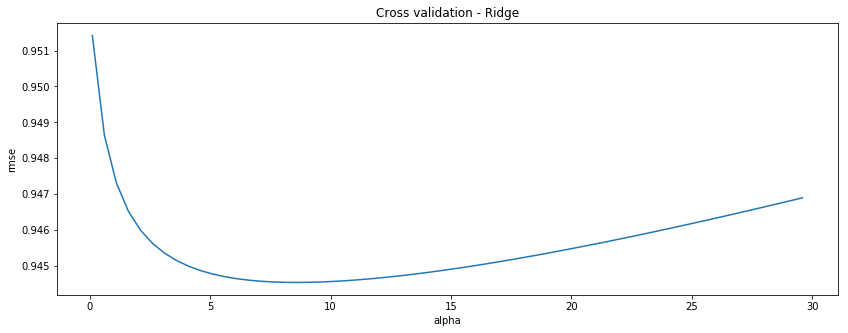

O melhor alpha é 8.6, com rmse = 0.9445355679218977


In [120]:
cv_ridge.plot(title = "Cross validation - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

print("O melhor alpha é {0}, com rmse = {1}".format(cv_ridge.idxmin(), cv_ridge.min()))

Ao aplicarmos a regularização Ridge, percebemos que o melhor alpha é 8.6, que gera um rmse de 0.9445 para os dados normalizados.

## Regressão com regularização Lasso

In [13]:
alphas_lasso = np.arange(0.0001,0.003,0.0001).tolist()

cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=10000)).mean()
            for alpha in alphas_lasso]

cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)

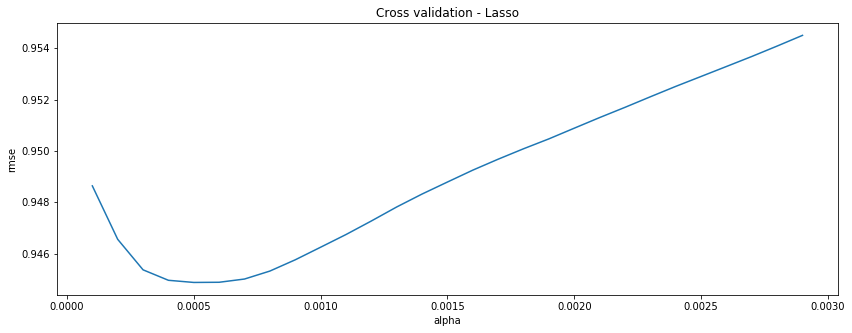

O melhor alpha é 0.0005, com rmse = 0.944877762062848


In [121]:
cv_lasso.plot(title = "Cross validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

print("O melhor alpha é {0}, com rmse = {1}".format(cv_lasso.idxmin(), cv_lasso.min()))

Ao aplicarmos a regularização Lasso, percebemos que o melhor alpha é 0.0005, que gera um rmse de 0.9449 para os dados normalizados.

## Modelo KNN

In [15]:
from sklearn.neighbors import KNeighborsRegressor

k_list = np.arange(15,40,1).tolist()

cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors = n)).mean()
            for n in k_list]

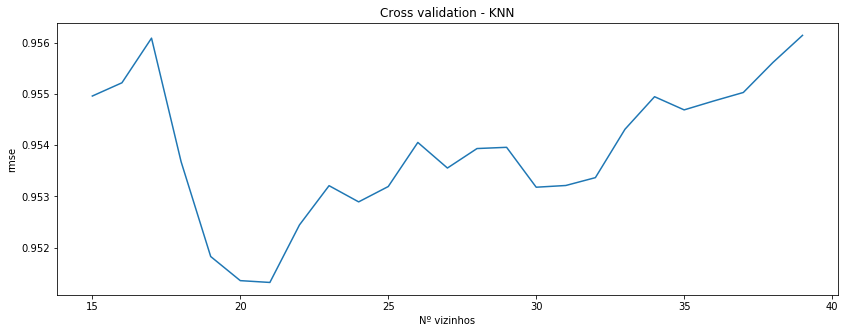

O melhor alpha é 21, com rmse = 0.9513186236709144


In [122]:
cv_knn = pd.Series(cv_knn, index = k_list)
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("rmse")
plt.show()

print("O melhor alpha é {0}, com rmse = {1}".format(cv_knn.idxmin(), cv_knn.min()))

Para o modelo KNN a quantidade de vizinhos que minimiza o rmse é 21, para os dados normalizados.

## Modelo Random Forest

Esse modelo possui dois hiperparâmetros principais, profundidade da arvore e quantidade de estimadores, além de alguns outros que não foram considerados para esse experimento. Por causa disso para encontrar a uma boa combinação desses hiperparâmetro, foram feitas duas rodadas em que na primeira foi fixado o número de estimadores em 100, incrementando a profundidade; e na segunda foi fixada a profundidade no melhor valor encontrado na rodada 1 e incrementou-se o número de estimadores.

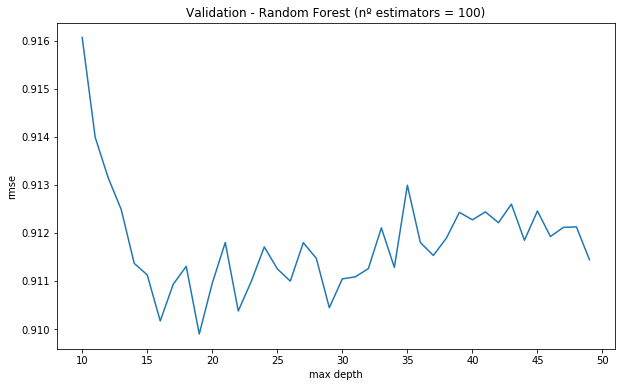

In [55]:
from sklearn.ensemble import RandomForestRegressor

depth_list = np.arange(10,50,1).tolist()

cv_forest = [rmse_cv(RandomForestRegressor(max_depth = max_depth, n_estimators=100, random_state=7)).mean()
            for max_depth in depth_list]

cv_forest = pd.Series(cv_forest, index = depth_list)
cv_forest.plot(title = "Cross validation - Random Forest (nº estimators = 100)")
plt.xlabel("max depth")
plt.ylabel("rmse")
plt.show()

In [56]:
print("A melhor profundidade (para estimators=100) é {0}, com rmse = {1}".format(cv_forest.idxmin(), cv_forest.min()))

A melhor profundidade (para estimators=100) é 19, com rmse = 0.9098958974062642


In [59]:
estimators_list = np.arange(100,1500,100).tolist()

cv_forest_dpMin = [rmse_cv(RandomForestRegressor(max_depth = cv_forest.idxmin(), n_estimators = n_estimators, random_state=7)).mean()
            for n_estimators in estimators_list]

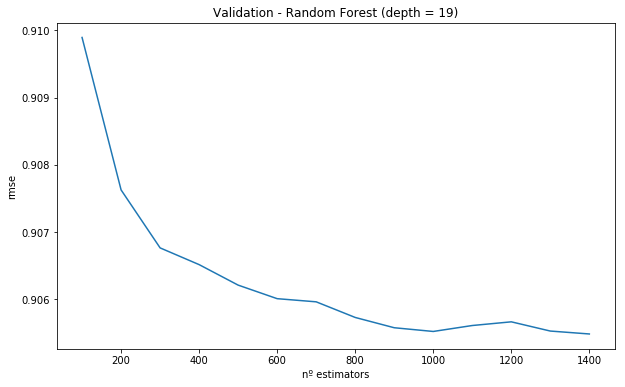

O melhor número de estimators (para profundidade=19) é 1400, com rmse = 0.905480890892283


In [60]:
cv_forest_dpMin = pd.Series(cv_forest_dpMin, index = estimators_list)
cv_forest_dpMin.plot(title = "Validation - Random Forest (depth = {0})".format(cv_forest.idxmin()))
plt.xlabel("nº estimators")
plt.ylabel("rmse")
plt.show()

print("O melhor número de estimators (para profundidade={0}) é {1}, com rmse = {2}".format(cv_forest.idxmin(), cv_forest_dpMin.idxmin(), cv_forest_dpMin.min()))

# Predições X Ruídos

Agora que foram encontrados os hiperparâmetros para cada modelo, eles serão validados calculando o rmse na escala logarítmica e real, bem como plotando o gráfico de predições vs ruídos.

## Ridge

In [17]:
Y_realValidation = np.expm1(Y_validation)

Aplicando função para retornar os dados da validação para escala original, para calcular o rmse e mostrar a disperção na escala original.

O rmse na validação do modelo Ridge é 0.9442781154467208 (escala logarítmica)


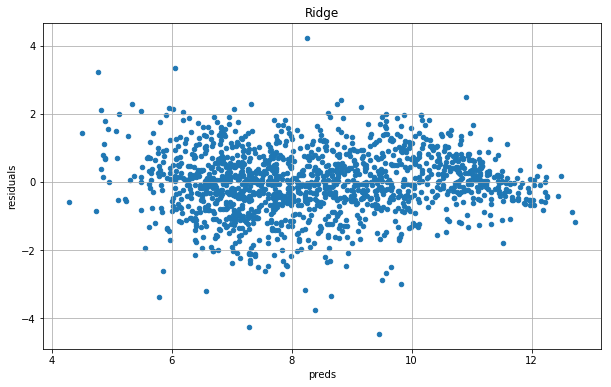

In [96]:
from sklearn.metrics import mean_squared_error

matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(X_train,Y_train)

preds_ridge = pd.DataFrame({"preds":model_ridge.predict(X_validation), "true":Y_validation})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)

rmse = np.sqrt(mean_squared_error(preds_ridge["true"],preds_ridge["preds"]))
print("O rmse na validação do modelo Ridge é {0} (escala logarítmica)".format(rmse))

O rmse na validação do modelo Ridge é 32104.06302132537 (escala original)


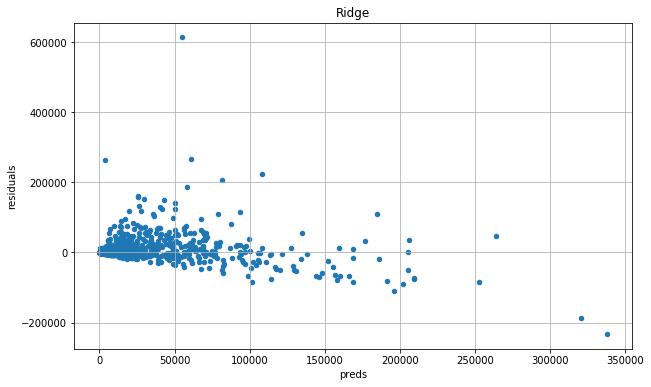

In [97]:
preds_ridge = pd.DataFrame({"preds":np.expm1(model_ridge.predict(X_validation)), "true":Y_realValidation})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)

rmse = np.sqrt(mean_squared_error(preds_ridge["true"],preds_ridge["preds"]))
print("O rmse na validação do modelo Ridge é {0} (escala original)".format(rmse))

## Lasso

O rmse na validação do modelo Lasso é 0.9447072844163099 (escala logarítmica)


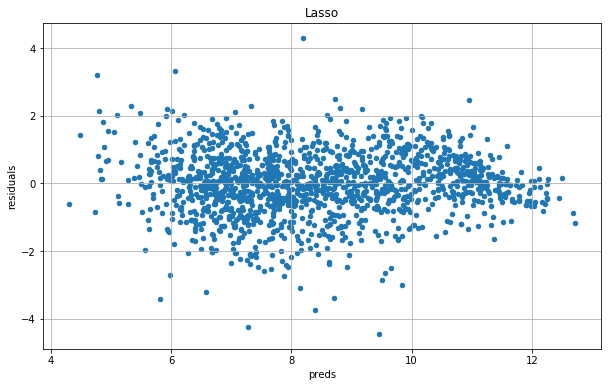

In [99]:
model_lasso = Lasso(alpha = cv_lasso.idxmin())
model_lasso.fit(X_train,Y_train)

preds_lasso = pd.DataFrame({"preds":model_lasso.predict(X_validation), "true":Y_validation})
preds_lasso["residuals"] = preds_lasso["true"] - preds_lasso["preds"]
preds_lasso.plot(x = "preds", y = "residuals",kind = "scatter", title = "Lasso", grid = True)

rmse = np.sqrt(mean_squared_error(preds_lasso["true"],preds_lasso["preds"]))
print("O rmse na validação do modelo Lasso é {0} (escala logarítmica)".format(rmse))

O rmse na validação do modelo Lasso é 32106.994606981396 (escala original)


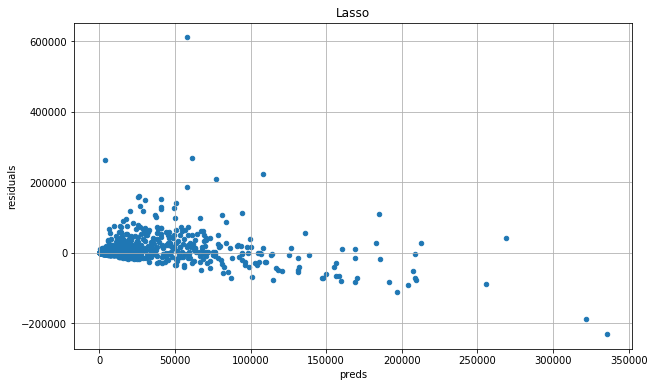

In [100]:
preds_lasso = pd.DataFrame({"preds":np.expm1(model_lasso.predict(X_validation)), "true":Y_realValidation})
preds_lasso["residuals"] = preds_lasso["true"] - preds_lasso["preds"]
preds_lasso.plot(x = "preds", y = "residuals",kind = "scatter", title = "Lasso", grid = True)

rmse = np.sqrt(mean_squared_error(preds_lasso["true"],preds_lasso["preds"]))
print("O rmse na validação do modelo Lasso é {0} (escala original)".format(rmse))

## KNN

O rmse na validação do modelo KNN é 0.9883743827402499 (escala logarítmica)


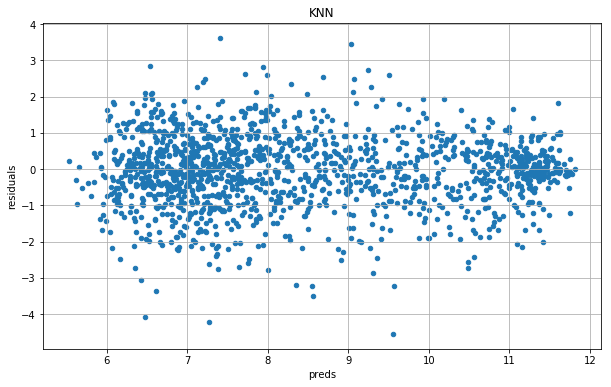

In [104]:
model_knn = KNeighborsRegressor(n_neighbors=cv_knn.idxmin())
model_knn.fit(X_train,Y_train)

preds_knn = pd.DataFrame({"preds":model_knn.predict(X_validation), "true":Y_validation})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
preds_knn.plot(x = "preds", y = "residuals",kind = "scatter", title = "KNN", grid = True)

rmse = np.sqrt(mean_squared_error(preds_knn["true"],preds_knn["preds"]))
print("O rmse na validação do modelo KNN é {0} (escala logarítmica)".format(rmse))

O rmse na validação do modelo KNN é 30392.65335739893 (escala original)


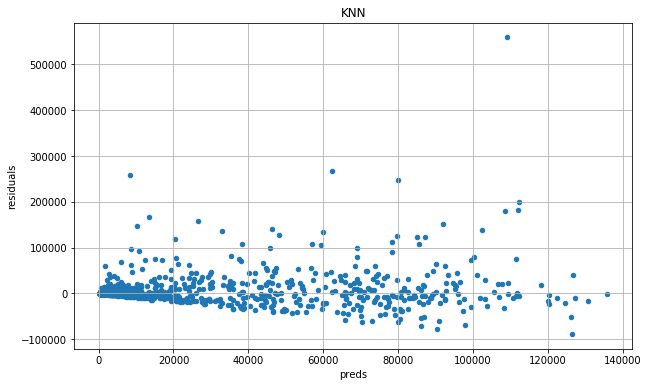

In [105]:
preds_knn = pd.DataFrame({"preds":np.expm1(model_knn.predict(X_validation)), "true":Y_realValidation})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
preds_knn.plot(x = "preds", y = "residuals",kind = "scatter", title = "KNN", grid = True)

rmse = np.sqrt(mean_squared_error(preds_knn["true"],preds_knn["preds"]))
print("O rmse na validação do modelo KNN é {0} (escala original)".format(rmse))

## Random Forest

O rmse na validação do modelo Random Forest é 0.9223198401612107 (escala logarítmica)


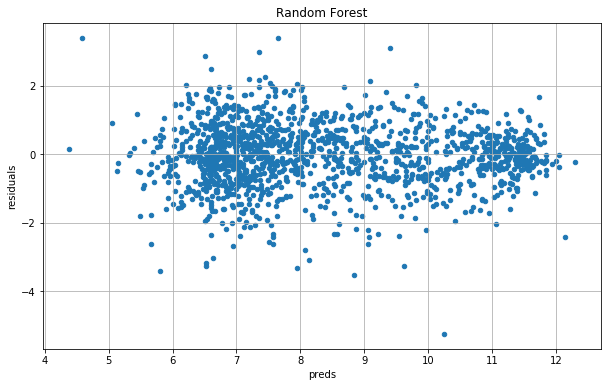

In [108]:
model_forest = RandomForestRegressor(max_depth = cv_forest.idxmin(), n_estimators = cv_forest_dpMin.idxmin(), random_state=7)
model_forest.fit(X_train,Y_train)

preds_forest = pd.DataFrame({"preds":model_forest.predict(X_validation), "true":Y_validation})
preds_forest["residuals"] = preds_forest["true"] - preds_forest["preds"]
preds_forest.plot(x = "preds", y = "residuals",kind = "scatter", title = "Random Forest", grid = True)

rmse = np.sqrt(mean_squared_error(preds_forest["true"],preds_forest["preds"]))
print("O rmse na validação do modelo Random Forest é {0} (escala logarítmica)".format(rmse))

O rmse na validação do modelo Random Forest é 28603.851013319738 (escala original)


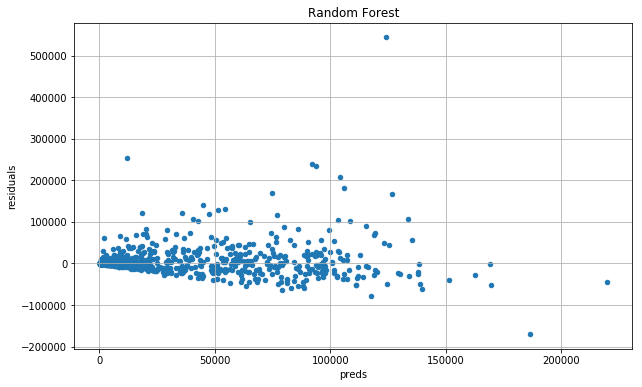

In [113]:
preds_forest = pd.DataFrame({"preds":np.expm1(model_forest.predict(X_validation)), "true":Y_realValidation})
preds_forest["residuals"] = preds_forest["true"] - preds_forest["preds"]
preds_forest.plot(x = "preds", y = "residuals",kind = "scatter", title = "Random Forest", grid = True)

rmse = np.sqrt(mean_squared_error(preds_forest["true"],preds_forest["preds"]))
print("O rmse na validação do modelo Random Forest é {0} (escala original)".format(rmse))

# Testando os modelos com dados de 2014

## Ridge

In [66]:
realTeste_alvo = np.expm1(teste_alvo)

O rmse no teste do modelo Ridge é 1.6992732502044507 (escala logarítmica)


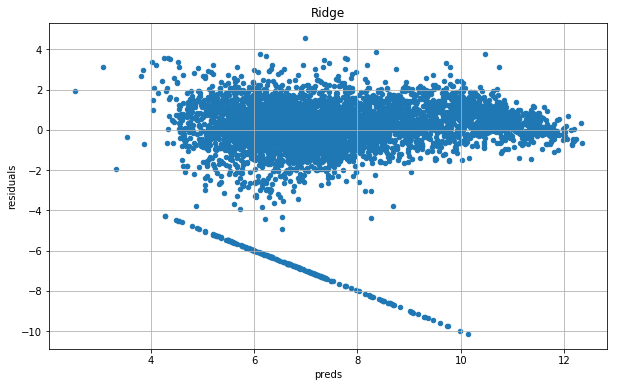

In [67]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(entradas, saida)

preds_ridge = pd.DataFrame({"preds":model_ridge.predict(teste_entradas), "true":teste_alvo})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)

rmse = np.sqrt(mean_squared_error(preds_ridge["true"],preds_ridge["preds"]))
print("O rmse no teste do modelo Ridge é {0} (escala logarítmica)".format(rmse))

É possível notar uma reta quase perfeita formando um padrão na parte inferior do gráfico, uma hipótese para explicar essa parte é a possibilidade desses pontos possuirem informações que não existiam nos dados de treino, como expliquei no início do lab.

O rmse no teste do modelo Ridge é 37415.61475230961


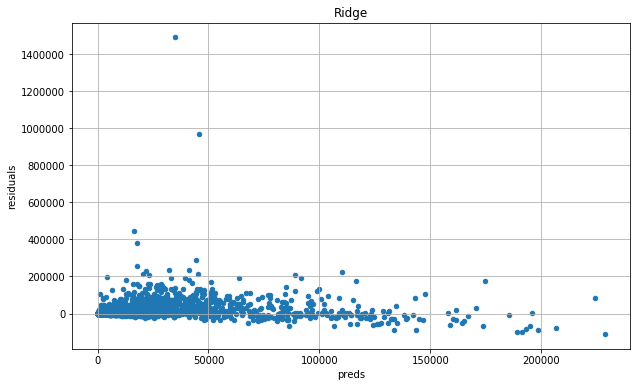

In [68]:
preds_ridge = pd.DataFrame({"preds":np.expm1(model_ridge.predict(teste_entradas)), "true":realTeste_alvo})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
x = preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)

rmse = np.sqrt(mean_squared_error(preds_ridge["true"],preds_ridge["preds"]))
print("O rmse no teste do modelo Ridge é {0} (escala original)".format(rmse))

No gráfico com a escala original dos dados também se percebe um comportamento "anormal" para esse tipo de gráfico, a maior parte dos pontos estão acima de 0. Para tentar resolver esse problema vou colocar alguns itens das eleições de 2014, que possuem informações que não existem nas eleições anteriores, no treino para que o modelo aprenda com os dados que não possuia antes.

O rmse no teste do modelo Lasso é 1.698408093924966 (em escala logarítmica)


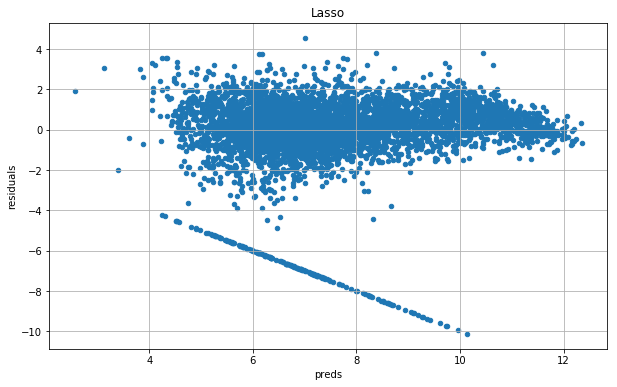

In [69]:
model_lasso = Lasso(alpha = cv_lasso.idxmin())
model_lasso.fit(entradas, saida)

preds_lasso = pd.DataFrame({"preds":model_lasso.predict(teste_entradas), "true":teste_alvo})
preds_lasso["residuals"] = preds_lasso["true"] - preds_lasso["preds"]
x = preds_lasso.plot(x = "preds", y = "residuals",kind = "scatter", title = "Lasso", grid = True)

rmse = np.sqrt(mean_squared_error(preds_lasso["true"],preds_lasso["preds"]))
print("O rmse no teste do modelo Lasso é {0} (escala logarítmica)".format(rmse))

O rmse no teste do modelo Lasso é 37432.2753218856 (na escala original)


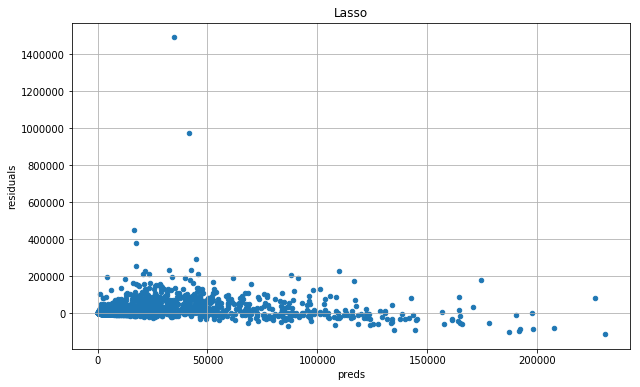

In [73]:
preds_lasso = pd.DataFrame({"preds":np.expm1(model_lasso.predict(teste_entradas)), "true":realTeste_alvo})
preds_lasso["residuals"] = preds_lasso["true"] - preds_lasso["preds"]
preds_lasso.plot(x = "preds", y = "residuals",kind = "scatter", title = "Lasso", grid = True)

rmse = np.sqrt(mean_squared_error(preds_lasso["true"],preds_lasso["preds"]))
print("O rmse no teste do modelo Lasso é {0} (escala original)".format(rmse))

O rmse no teste do modelo KNN é 1.8147861344370555 (em escala logarítmica)


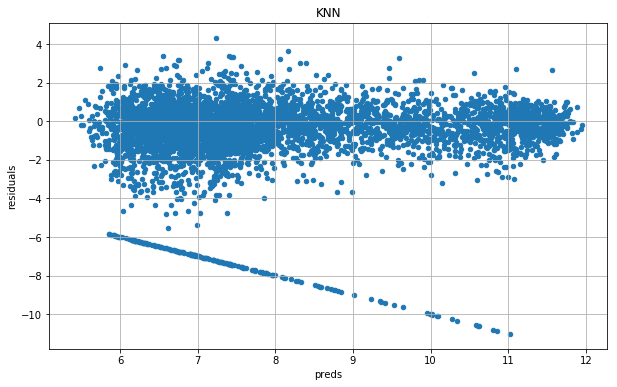

In [72]:
model_knn = KNeighborsRegressor(n_neighbors=cv_knn.idxmin())
model_knn.fit(entradas, saida)

preds_knn = pd.DataFrame({"preds":model_knn.predict(teste_entradas), "true":teste_alvo})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
x = preds_knn.plot(x = "preds", y = "residuals",kind = "scatter", title = "KNN", grid = True)

rmse = np.sqrt(mean_squared_error(preds_knn["true"],preds_knn["preds"]))
print("O rmse no teste do modelo KNN é {0} (escala logarítmica)".format(rmse))

O rmse no teste do modelo KNN é 34214.59439547476 (na escala original)


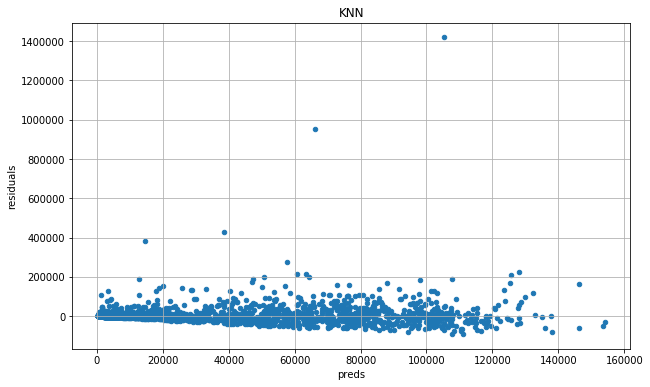

In [75]:
preds_knn = pd.DataFrame({"preds":np.expm1(model_knn.predict(teste_entradas)), "true":realTeste_alvo})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
x = preds_knn.plot(x = "preds", y = "residuals",kind = "scatter", title = "KNN", grid = True)

rmse = np.sqrt(mean_squared_error(preds_knn["true"],preds_knn["preds"]))
print("O rmse no teste do modelo KNN é {0} (escala original)".format(rmse))

O rmse no teste do modelo Random Forest é 1.7738248964384429 (na escala logarítmica)


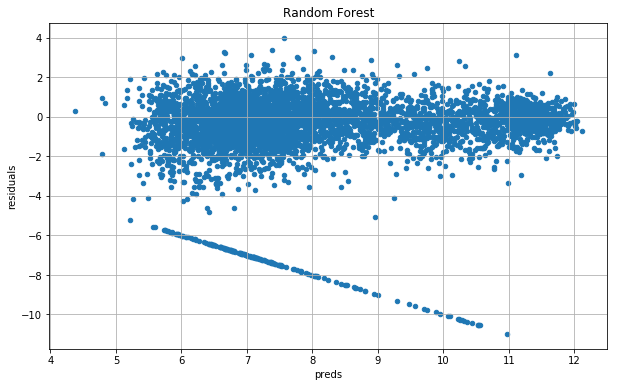

In [76]:
model_forest = RandomForestRegressor(max_depth=cv_forest.idxmin(), n_estimators=cv_forest_dpMin.idxmin(), random_state=7)
model_forest.fit(entradas, saida)

preds_forest = pd.DataFrame({"preds":model_forest.predict(teste_entradas), "true":teste_alvo})
preds_forest["residuals"] = preds_forest["true"] - preds_forest["preds"]
preds_forest.plot(x = "preds", y = "residuals",kind = "scatter", title = "Random Forest", grid = True)

rmse = np.sqrt(mean_squared_error(preds_forest["true"],preds_forest["preds"]))
print("O rmse no teste do modelo Random Forest é {0} (escala logarítmica)".format(rmse))

O rmse no teste do modelo Random Forest é 33459.8145097736 (na escala original)


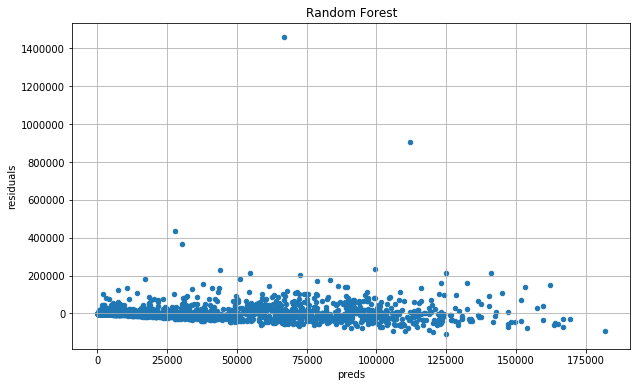

In [77]:
preds_forest = pd.DataFrame({"preds":np.expm1(model_forest.predict(teste_entradas)), "true":realTeste_alvo})
preds_forest["residuals"] = preds_forest["true"] - preds_forest["preds"]
preds_forest.plot(x = "preds", y = "residuals",kind = "scatter", title = "Random Forest", grid = True)

rmse = np.sqrt(mean_squared_error(preds_forest["true"],preds_forest["preds"]))
print("O rmse no teste do modelo Random Forest é {0} (escala original)".format(rmse))

# Conclusão